In [4]:
from dotenv import load_dotenv
load_dotenv('.env-db')
from utils.utils import get_database
from transformers import LlamaTokenizerFast
tokenizer = LlamaTokenizerFast.from_pretrained('hf-internal-testing/llama-tokenizer')
import pandas as pd
def count_tokens(prompt):
    return len(tokenizer.tokenize(prompt))

/Users/vaishakkrishna/Documents/XLNC_WORK/calibration-scripts/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [18]:
db = get_database()
llm_name = 'baichuan-inc/Baichuan-13B-Base'
dim = 'contrast'
# llm_name = 'OpenAssistant/llama2-13b-orca-8k-3319'
# all_ratings_llm = pd.DataFrame(list(db[f'queries/{llm_name}/{dim}'].find({})))
# all_ratings_llm = pd.DataFrame(list(db[f'queries/{dim}/{llm_name}'].find({})))


In [20]:
all_queries = list(db[f'queries/reference/{dim}'].find({}))
# db[f'queries/{llm_name}/{dim}'].insert_many(all_queries)

In [21]:
len(all_queries)

411336

In [22]:
db[f'queries/{llm_name}/{dim}'].insert_many(all_queries)

Average latency: 0.38120140628551324


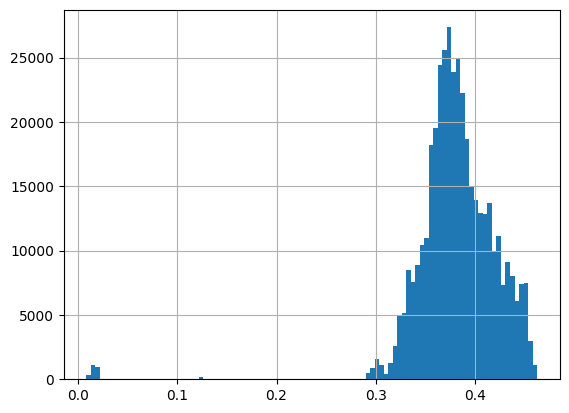

In [10]:
# get average latency
latencies = list(db[f'queries/{llm_name}/{dim}'].find({"latency":{"$gt":0}}))
latencies = pd.DataFrame(latencies)
latencies['latency'].hist(bins=100)
print(f"Average latency: {sum(latencies['latency'])/len(latencies['latency'])}")

<Axes: >

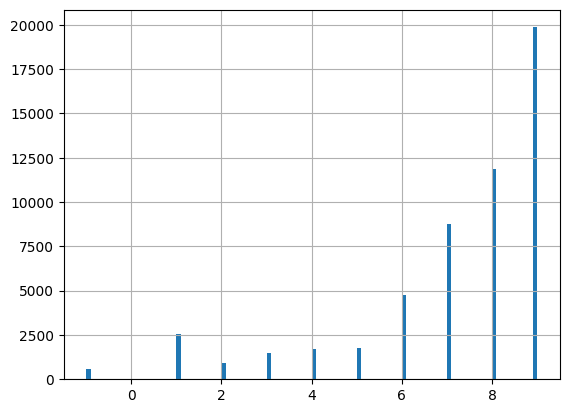

In [15]:
latencies['rating'].hist(bins=100)

In [ ]:
# import tqdm
# # display dist. of prompt lengths
# dim = 'contrast'
# prefixes = {prefix['prefix_index']:prefix for prefix in list(db['prefixes'].find({}))}
# prompts = {prompt['prompt_index']:prompt for prompt in list(db[f'core_prompts/{dim}'].find({}))}
# samples = {sample['sample_index']:sample for sample in list(db[f'samples/{dim}'].find({}))}
# tokens_dist = []
# prefix = max(prefixes.values(), key=lambda x : len(x['prefix']))
# for prompt in tqdm.tqdm(prompts):
#     for sample in samples:
#         t = count_tokens(prefix['prefix'] + prompts[prompt]['combined_prompt'] + samples[sample]['sample'])
#         tokens_dist.append(t)
# pd.Series(tokens_dist).hist(bins=100)

In [13]:
import tqdm
skip_prefix_severe = ['reciprocity', 'unity', 'scarcity']
for dim in ['authority']:
    query_docs = []
    print("UPLOADING DIMENSION", dim)
    all_dim_prompts = list(db[f'core_prompts/{dim}'].find({}))
    all_dim_samples = list(db[f'samples/{dim}'].find({}))
    all_prefixes = list(db[f'prefixes'].find({}))
    for prefix_doc in tqdm.tqdm(all_prefixes):
        prefix_ind = prefix_doc['prefix_index']
        if prefix_ind == 2 and dim in skip_prefix_severe:
            continue
        for prompt_doc in all_dim_prompts:
            for sample_doc in all_dim_samples:
                query_doc = {
                    'prefix_index': prefix_doc['prefix_index'],
                    'prompt_index': prompt_doc['prompt_index'],
                    'sample_index': sample_doc['sample_index'],
                    'dimension': dim,
                    'latency': -1.0,
                    'num_tries': 0,
                    'rating': -1,
                }
                query_docs.append(query_doc)

UPLOADING DIMENSION authority


100%|██████████| 6/6 [00:00<00:00, 35.62it/s]
